## Table of Contents
1) [Gather](#Gather) \
2) [Assess](#Assess) \
3) [Quality](#Quality) \
        - [Drop the retweet columns](#Drop-the-retweet-columns) \
        - [Names in P1,P2,P3 made uniform](#Names-in-P1,P2,P3-made-uniform)\
        - [Combine data frames into one](#Combine-data-frames-into-one) \
        - [Check for duplicates](#Check-for-duplicates) \
        - [Drop tweet ids that do not have image predictions or retweet counts](#Drop-tweet-ids-that-do-not-have-image-predictions-or-retweet-counts)\
        - [Drop irrelevant columns](#Drop-irrelevant-columns) \
        - [Convert the colums to relevant datatypes](#Convert-the-colums-to-relevant-datatypes) \
        - [Identify the different dog stages and clean](#Identify-the-different-dog-stages-and-clean) \
        - [Clean the text length column](#Clean-the-text-length-column)\
        - [Change tweet id name as a same column in all dataframes (T1)](#Change-tweet-id-name-as-a-same-column-in-all-dataframes-(T1))\
       -  [Combine the dog stages into one (T2)](#Combine-the-dog-stages-into-one-(T2))
        
4) [Analyse](#Analysis)\
5) [Insights](#Insights)\
6) [Reference](#Reference)

In [1]:
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


# Gather

In [2]:
df_1=pd.read_csv('twitter-archive-enhanced.csv')
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
df_new = df_1.copy()
df_new.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
df_new = df_new[df_new.retweeted_status_id.isnull()]
df_new= df_new[df_new.retweeted_status_user_id.isnull()]
df_new = df_new[df_new.retweeted_status_timestamp.isnull()]

Used the text file for tweet data. Also used the image predictions csv.

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
image_predictions  = pd.read_csv('image_predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
imagep=image_predictions.copy()

In [7]:
import pandas as pd
json_df=pd.read_json('tweet-json.txt', lines=True)
json_df.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [8]:
data = []
with open('tweet-json.txt') as f:    
        for line in f:         
             data.append(json.loads(line))
#create dataframe from json data
df_api = pd.DataFrame(data)
#select columns of interest
columns_of_interest = ['id', 'retweet_count', 'favorite_count', 'display_text_range']
df_api = df_api[columns_of_interest]
df_api.head()

,id,retweet_count,favorite_count,display_text_range
0,892420643555336193,8853,39467,"[0, 85]"
1,892177421306343426,6514,33819,"[0, 138]"
2,891815181378084864,4328,25461,"[0, 121]"
3,891689557279858688,8964,42908,"[0, 79]"
4,891327558926688256,9774,41048,"[0, 138]"


## Assess
In total there are 3 dataframes I have
df_new : containing the twitter archive enhanced data
df_api : which is the extract from json for the tweet data instead of using the twitter api
imagep: the extract of image predictions csv


In [9]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [10]:
df_new.tweet_id.nunique()

2175

In [11]:
df_new.tweet_id.duplicated

<bound method Series.duplicated of 0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
               ...        
2351    666049248165822465
2352    666044226329800704
2353    666033412701032449
2354    666029285002620928
2355    666020888022790149
Name: tweet_id, Length: 2175, dtype: int64>

In [12]:
imagep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2354 non-null   int64 
 1   retweet_count       2354 non-null   int64 
 2   favorite_count      2354 non-null   int64 
 3   display_text_range  2354 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


In [14]:
imagep.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
basketball              1
sarong                  1
water_buffalo           1
assault_rifle           1
handkerchief            1
Name: p2, Length: 405, dtype: int64

In [15]:
imagep.p2.unique()

array(['collie', 'miniature_pinscher', 'malinois', 'redbone',
       'Rottweiler', 'English_springer', 'mud_turtle', 'Tibetan_mastiff',
       'shopping_basket', 'komondor', 'Yorkshire_terrier',
       'English_foxhound', 'bull_mastiff', 'German_shepherd', 'Shih-Tzu',
       'Newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'Chesapeake_Bay_retriever', 'Siberian_husky', 'skunk',
       'Afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow', 'Irish_terrier', 'chain_saw', 'beagle',
       'giant_schnauzer', 'Labrador_retriever', 'Pembroke', 'Chihuahua',
       'Weimaraner', 'slug', 'Brittany_spaniel', 'standard_schnauzer',
       'teddy', 'armadillo', 'African_hunting_dog', 'vizsla', 'doormat',
       'pug', 'Italian_greyhound', 'Samoyed', 'Pomeranian',
       'miniature_poodle', 'Lakeland_terrier', 'Irish_setter', 'swab',
       'malamute', 'bath_towel', 'Border_collie', 'Leonberg', 'drake',
       'French_bulldog', 'ice_bear', 

In [16]:
imagep.p2=imagep.p2.str.replace('_', ' ', regex=True)
imagep.p1=imagep.p1.str.replace('_', ' ', regex=True)
imagep.p3=imagep.p3.str.replace('_', ' ', regex=True)
#df.columns = df.columns.str.replace(' ', '_')

In [17]:
imagep.p2.unique()

array(['collie', 'miniature pinscher', 'malinois', 'redbone',
       'Rottweiler', 'English springer', 'mud turtle', 'Tibetan mastiff',
       'shopping basket', 'komondor', 'Yorkshire terrier',
       'English foxhound', 'bull mastiff', 'German shepherd', 'Shih-Tzu',
       'Newfoundland', 'cock', 'desk', 'toy terrier', 'toy poodle',
       'otter', 'Chesapeake Bay retriever', 'Siberian husky', 'skunk',
       'Afghan hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker spaniel', 'chow', 'Irish terrier', 'chain saw', 'beagle',
       'giant schnauzer', 'Labrador retriever', 'Pembroke', 'Chihuahua',
       'Weimaraner', 'slug', 'Brittany spaniel', 'standard schnauzer',
       'teddy', 'armadillo', 'African hunting dog', 'vizsla', 'doormat',
       'pug', 'Italian greyhound', 'Samoyed', 'Pomeranian',
       'miniature poodle', 'Lakeland terrier', 'Irish setter', 'swab',
       'malamute', 'bath towel', 'Border collie', 'Leonberg', 'drake',
       'French bulldog', 'ice bear', 

In [18]:
len(imagep.p2.unique())

405

In [19]:
imagep.tweet_id.duplicated

<bound method Series.duplicated of 0       666020888022790149
1       666029285002620928
2       666033412701032449
3       666044226329800704
4       666049248165822465
               ...        
2070    891327558926688256
2071    891689557279858688
2072    891815181378084864
2073    892177421306343426
2074    892420643555336193
Name: tweet_id, Length: 2075, dtype: int64>

In [20]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [21]:
json_df.id.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2349    False
2350    False
2351    False
2352    False
2353    False
Name: id, Length: 2354, dtype: bool

In [22]:
len(imagep.p1.unique())

378

In [23]:
all_columns = pd.Series(list(df_new) + list(imagep)+ list(json_df))
all_columns[all_columns.duplicated()]

17                 tweet_id
37                   source
38    in_reply_to_status_id
40      in_reply_to_user_id
dtype: object

In [24]:
pd.Series(list(df_new)).duplicated().count()

17

In [25]:
df_new.expanded_urls.isnull().count()

2175

In [26]:
df_new.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.175000e+03,7.800000e+01,7.800000e+01,0.0,0.0,2175.000000,2175.000000
mean,7.371205e+17,7.455079e+17,2.014171e+16,NaN,NaN,13.215172,10.492874
std,6.748668e+16,7.582492e+16,1.252797e+17,NaN,NaN,47.725696,7.019084
min,6.660209e+17,6.658147e+17,1.185634e+07,NaN,NaN,0.000000,0.000000
25%,6.768432e+17,6.757419e+17,3.086374e+08,NaN,NaN,10.000000,10.000000
50%,7.098528e+17,7.038708e+17,4.196984e+09,NaN,NaN,11.000000,10.000000
75%,7.894226e+17,8.257804e+17,4.196984e+09,NaN,NaN,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,NaN,NaN,1776.000000,170.000000


In [27]:
imagep.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


## Quality
### Cleanliness

- Drop the retweet columns
- Names in P1, P2, P3 can be made uniform
- Duplicated tweet id identify
- Drop tweet ids that do not have image predictions or retweet counts
- drop the columns not needed for the analysis
- Proper datatypes for the columns, either str or int
- Identify different dog stages
- clean the text length column and extract only the text length values
- Change the tweet_id column name to the same one in all dataframes for further analysis


### Tidiness
- Combine needed columns into one DF
- combine dog stages column into one


#### The final df used for the anlaysis below is df which has necessary columns extracted from the above mentioned 3 Dataframes

## Code

#### Drop the retweet columns

In [28]:
df_new = df_new[df_new.retweeted_status_id.isnull()]
df_new= df_new[df_new.retweeted_status_user_id.isnull()]
df_new = df_new[df_new.retweeted_status_timestamp.isnull()]

#### Names in P1,P2,P3 made uniform

In [29]:
imagep.p2=imagep.p2.str.replace('_', ' ', regex=True)
imagep.p1=imagep.p1.str.replace('_', ' ', regex=True)
imagep.p3=imagep.p3.str.replace('_', ' ', regex=True)
#df.columns = df.columns.str.replace(' ', '_')

#### Change tweet id name as a same column in all dataframes (T1)

In [30]:
df_api = df_api.rename(columns={"id":"tweet_id"})
df_api.head()
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2354 non-null   int64 
 1   retweet_count       2354 non-null   int64 
 2   favorite_count      2354 non-null   int64 
 3   display_text_range  2354 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


#### Combine data frames into one

In [31]:
df= pd.merge(df_api, df_new, on='tweet_id')

df

,tweet_id,retweet_count,favorite_count,display_text_range,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,8853,39467,"[0, 85]",NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,6514,33819,"[0, 138]",NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,4328,25461,"[0, 121]",NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,8964,42908,"[0, 79]",NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,9774,41048,"[0, 138]",NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,666049248165822465,41,111,"[0, 120]",NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2171,666044226329800704,147,311,"[0, 137]",NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2172,666033412701032449,47,128,"[0, 130]",NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2173,666029285002620928,48,132,"[0, 139]",NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   retweet_count               2175 non-null   int64  
 2   favorite_count              2175 non-null   int64  
 3   display_text_range          2175 non-null   object 
 4   in_reply_to_status_id       78 non-null     float64
 5   in_reply_to_user_id         78 non-null     float64
 6   timestamp                   2175 non-null   object 
 7   source                      2175 non-null   object 
 8   text                        2175 non-null   object 
 9   retweeted_status_id         0 non-null      float64
 10  retweeted_status_user_id    0 non-null      float64
 11  retweeted_status_timestamp  0 non-null      object 
 12  expanded_urls               2117 non-null   object 
 13  rating_numerator            2175 

####  Check for duplicates

#### Drop tweet ids that do not have image predictions or retweet counts
With merging, it drops rows without all the info

In [33]:
df= pd.merge(df, imagep, on='tweet_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1994 non-null   int64  
 1   retweet_count               1994 non-null   int64  
 2   favorite_count              1994 non-null   int64  
 3   display_text_range          1994 non-null   object 
 4   in_reply_to_status_id       23 non-null     float64
 5   in_reply_to_user_id         23 non-null     float64
 6   timestamp                   1994 non-null   object 
 7   source                      1994 non-null   object 
 8   text                        1994 non-null   object 
 9   retweeted_status_id         0 non-null      float64
 10  retweeted_status_user_id    0 non-null      float64
 11  retweeted_status_timestamp  0 non-null      object 
 12  expanded_urls               1994 non-null   object 
 13  rating_numerator            1994 

#### Drop irrelevant columns

In [34]:
columns = ['source','in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']
df.drop(columns, inplace=True, axis=1)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   retweet_count       1994 non-null   int64  
 2   favorite_count      1994 non-null   int64  
 3   display_text_range  1994 non-null   object 
 4   timestamp           1994 non-null   object 
 5   text                1994 non-null   object 
 6   expanded_urls       1994 non-null   object 
 7   rating_numerator    1994 non-null   int64  
 8   rating_denominator  1994 non-null   int64  
 9   name                1994 non-null   object 
 10  doggo               1994 non-null   object 
 11  floofer             1994 non-null   object 
 12  pupper              1994 non-null   object 
 13  puppo               1994 non-null   object 
 14  jpg_url             1994 non-null   object 
 15  img_num             1994 non-null   int64  
 16  p1    

#### Convert the colums to relevant datatypes

#### Combine the dog stages into one (T2)

In [36]:
df['stages']=df['doggo']+df['floofer']+df['pupper']+df['puppo']

In [37]:
df.head()

,tweet_id,retweet_count,favorite_count,display_text_range,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages
0,892420643555336193,8853,39467,"[0, 85]",2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,NoneNoneNoneNone
1,892177421306343426,6514,33819,"[0, 138]",2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,NoneNoneNoneNone
2,891815181378084864,4328,25461,"[0, 121]",2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,NoneNoneNoneNone
3,891689557279858688,8964,42908,"[0, 79]",2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,paper towel,0.170278,False,Labrador retriever,0.168086,True,spatula,0.040836,False,NoneNoneNoneNone
4,891327558926688256,9774,41048,"[0, 138]",2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,basset,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,NoneNoneNoneNone


#### Identify the different dog stages and clean

In [38]:
df.stages.unique()

array(['NoneNoneNoneNone', 'doggoNoneNoneNone', 'NoneNoneNonepuppo',
       'NoneNonepupperNone', 'NoneflooferNoneNone', 'doggoNoneNonepuppo',
       'doggoflooferNoneNone', 'doggoNonepupperNone'], dtype=object)

In [39]:
df.loc[(df.stages == 'NoneNoneNoneNone'),'stages']='None'
df.loc[(df.stages == 'doggoNoneNoneNone'),'stages']='doggo'
df.loc[(df.stages == 'NoneNoneNonepuppo'),'stages']='puppo'
df.loc[(df.stages == 'NoneNonepupperNone'),'stages']='pupper'
df.loc[(df.stages == 'NoneflooferNoneNone'),'stages']='floofer'
df.loc[(df.stages == 'doggoNoneNonepuppo'),'stages']='doggo and puppo'
df.loc[(df.stages == 'doggoflooferNoneNone'),'stages']='doggo and floofer'
df.loc[(df.stages == 'doggoNonepupperNone'),'stages']='doggo and pupper'

In [40]:
#a= (df['display_text_range'][0])
#c=a.extract('\[(.+)]', '').strip()
df['text_length'] = df['display_text_range'].str.extract(r'\[(.+)]')
df['tex_length'] = df['text_length'].str.strip(r'(^0\,\s)')
df.head()

,tweet_id,retweet_count,favorite_count,display_text_range,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stages,text_length,tex_length
0,892420643555336193,8853,39467,"[0, 85]",2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,False,bagel,0.085851,False,banana,0.076110,False,None,NaN,NaN
1,892177421306343426,6514,33819,"[0, 138]",2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,True,Pekinese,0.090647,True,papillon,0.068957,True,None,NaN,NaN
2,891815181378084864,4328,25461,"[0, 121]",2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,True,malamute,0.078253,True,kelpie,0.031379,True,None,NaN,NaN
3,891689557279858688,8964,42908,"[0, 79]",2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,False,Labrador retriever,0.168086,True,spatula,0.040836,False,None,NaN,NaN
4,891327558926688256,9774,41048,"[0, 138]",2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,None,NaN,NaN


In [41]:
df.stages.unique()

array(['None', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo and puppo',
       'doggo and floofer', 'doggo and pupper'], dtype=object)

In [42]:
df[['None', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo and puppo',
       'doggo and floofer', 'doggo and pupper']] = pd.get_dummies(df['stages'])

In [43]:
df.head()

,tweet_id,retweet_count,favorite_count,display_text_range,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,...,p3,p3_conf,p3_dog,stages,text_length,tex_length,None,doggo and puppo,doggo and floofer,doggo and pupper
0,892420643555336193,8853,39467,"[0, 85]",2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,banana,0.076110,False,None,NaN,NaN,1,0,0,0
1,892177421306343426,6514,33819,"[0, 138]",2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,papillon,0.068957,True,None,NaN,NaN,1,0,0,0
2,891815181378084864,4328,25461,"[0, 121]",2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,kelpie,0.031379,True,None,NaN,NaN,1,0,0,0
3,891689557279858688,8964,42908,"[0, 79]",2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,spatula,0.040836,False,None,NaN,NaN,1,0,0,0
4,891327558926688256,9774,41048,"[0, 138]",2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,German short-haired pointer,0.175219,True,None,NaN,NaN,1,0,0,0


#### Clean the text length column

Code only worked sometimes, hence couldnt use it in analysis. Intention was to see popularity, accuracy in prediction for tweets which were long.

In [44]:
df['text_length'] = df['display_text_range'].str.extract(r'\[(.+)]')
df['tex_length'] = df['text_length'].str.strip(r'(^0\,\s)')
df.head()

,tweet_id,retweet_count,favorite_count,display_text_range,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,...,p3,p3_conf,p3_dog,stages,text_length,tex_length,None,doggo and puppo,doggo and floofer,doggo and pupper
0,892420643555336193,8853,39467,"[0, 85]",2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,banana,0.076110,False,None,NaN,NaN,1,0,0,0
1,892177421306343426,6514,33819,"[0, 138]",2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,papillon,0.068957,True,None,NaN,NaN,1,0,0,0
2,891815181378084864,4328,25461,"[0, 121]",2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,kelpie,0.031379,True,None,NaN,NaN,1,0,0,0
3,891689557279858688,8964,42908,"[0, 79]",2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,spatula,0.040836,False,None,NaN,NaN,1,0,0,0
4,891327558926688256,9774,41048,"[0, 138]",2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,German short-haired pointer,0.175219,True,None,NaN,NaN,1,0,0,0


In [45]:
df['display_text_range'].describe()

count         1994
unique         114
top       [0, 140]
freq           175
Name: display_text_range, dtype: object

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   retweet_count       1994 non-null   int64  
 2   favorite_count      1994 non-null   int64  
 3   display_text_range  1994 non-null   object 
 4   timestamp           1994 non-null   object 
 5   text                1994 non-null   object 
 6   expanded_urls       1994 non-null   object 
 7   rating_numerator    1994 non-null   int64  
 8   rating_denominator  1994 non-null   int64  
 9   name                1994 non-null   object 
 10  doggo               1994 non-null   uint8  
 11  floofer             1994 non-null   uint8  
 12  pupper              1994 non-null   uint8  
 13  puppo               1994 non-null   uint8  
 14  jpg_url             1994 non-null   object 
 15  img_num             1994 non-null   int64  
 16  p1    

## Analysis

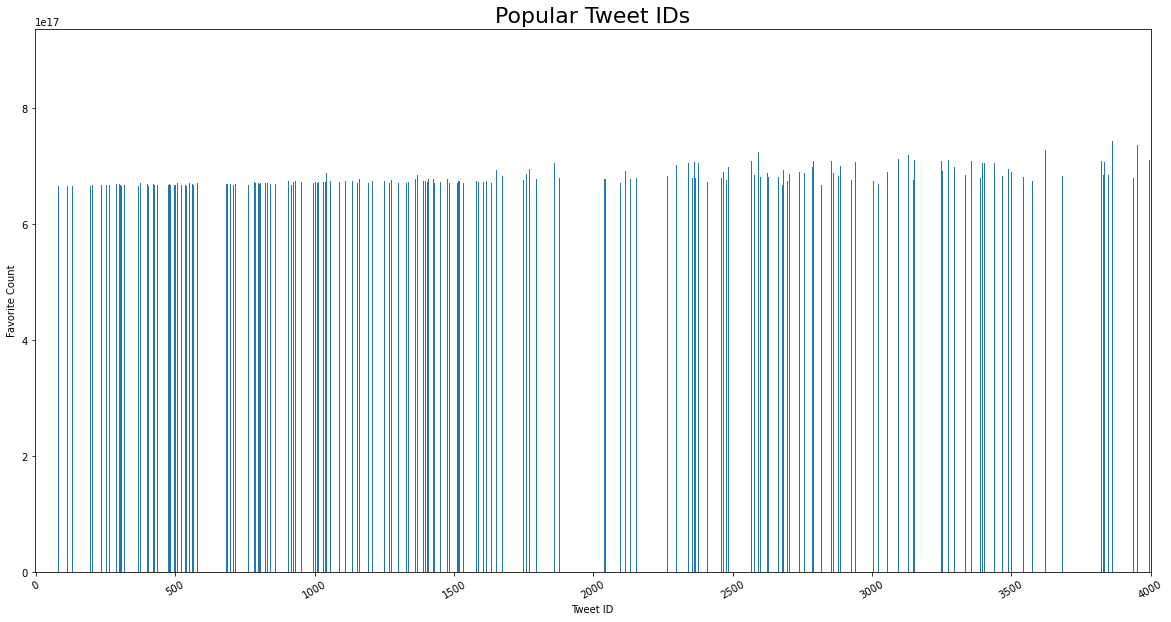

In [47]:
ax = plt.subplots(figsize=(20,10))
plt.title("Popular Tweet IDs", fontsize=22)
plt.xticks(rotation=30)
plt.ylabel('Favorite Count')
plt.xlabel('Tweet ID')
plt.xlim(-5,4000)
plt.bar((df.favorite_count),(df.tweet_id) );

Text(0, 0.5, 'Favorite Count')

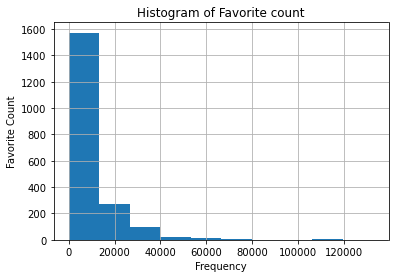

In [48]:
df.favorite_count.hist()
plt.title('Histogram of Favorite count')
plt.xlabel('Frequency')
plt.ylabel('Favorite Count')

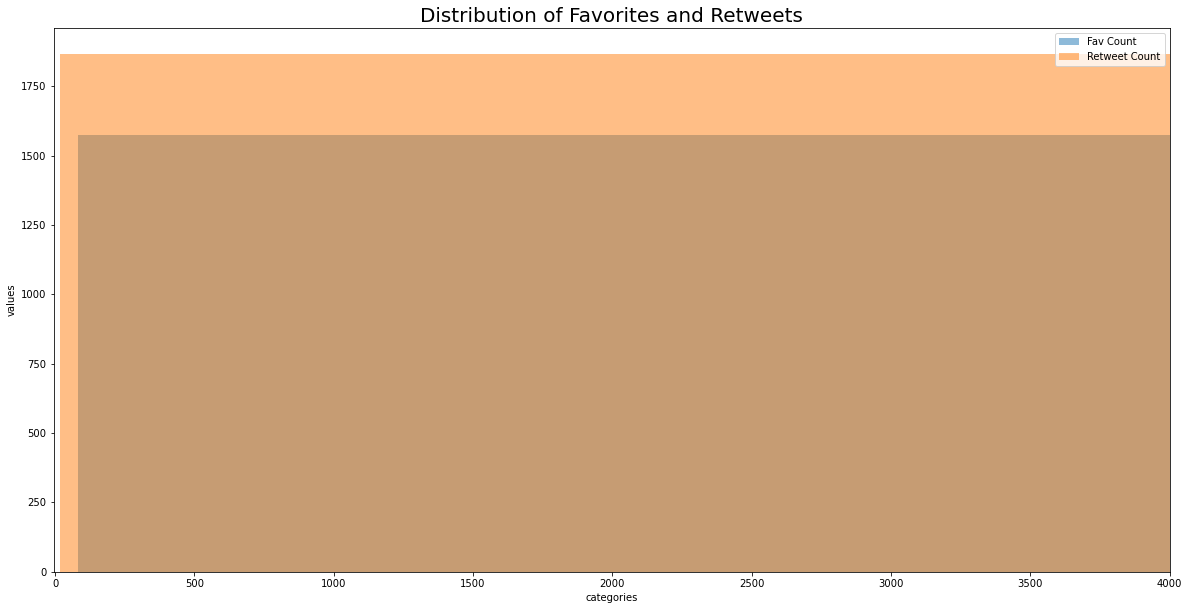

In [49]:
fig, ax=plt.subplots(figsize=(20,10))
ax.hist(df.favorite_count, alpha=0.5, label='Fav Count')
ax.hist(df.retweet_count, alpha=0.5, label='Retweet Count')
ax.legend(loc='upper right')
plt.xlim(-5,4000)
plt.title('Distribution of Favorites and Retweets', fontsize=20)
plt.xlabel('categories')
plt.ylabel('values')
plt.show();

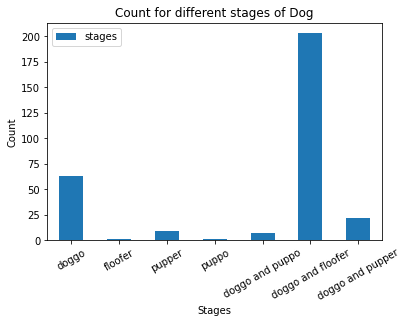

In [50]:
plotdata = pd.DataFrame(
    {"stages": [df.doggo.sum(),df.floofer.sum(),df.pupper.sum(),df.puppo.sum(),(df['doggo and puppo'].sum()),(df['doggo and floofer'].sum()),(df['doggo and pupper'].sum())]}, 
    index=["doggo", "floofer", "pupper", "puppo", "doggo and puppo", "doggo and floofer", "doggo and pupper"])
# Plot a bar chart
plotdata.plot(kind="bar")
plt.title("Count for different stages of Dog")
plt.xlabel("Stages")
plt.ylabel("Count")
plt.xticks(rotation=30, horizontalalignment="center");

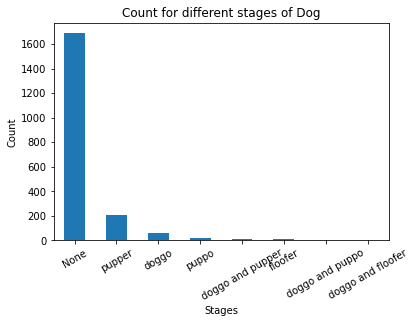

In [51]:
x=df.stages.value_counts()
x.plot(kind="bar")
plt.title("Count for different stages of Dog")
plt.xlabel("Stages")
plt.ylabel("Count")
plt.xticks(rotation=30, horizontalalignment="center");

In [52]:
tot=df.tweet_id.count()*3

p3T=(df['p3_dog']==True).sum()
p3F=(df['p3_dog']==False).sum()
p1F=(df['p1_dog']==False).sum()
p1T=(df['p1_dog']==True).sum()
p2F=(df['p2_dog']==False).sum()
p2T=(df['p2_dog']==True).sum()

<Figure size 1080x576 with 0 Axes>

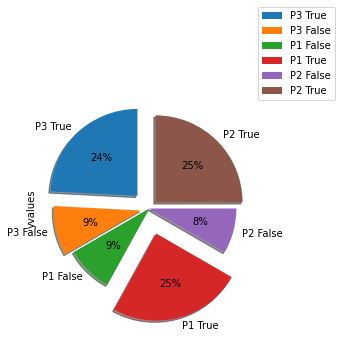

In [53]:
pltdata = pd.DataFrame({'yvalues':[p3T,p3F,p1F,p1T,p2F,p2T]},index=['P3 True','P3 False', 'P1 False', 'P1 True', 'P2 False', 'P2 True'])
ex=[0.2,0.1,0,0.3,0,0.1]
plt.figure(figsize=(15,8))
pltdata.plot(kind='pie',y='yvalues',explode=ex,shadow=True,startangle=90, autopct='%.0f%%')
plt.legend(loc=(1,1));

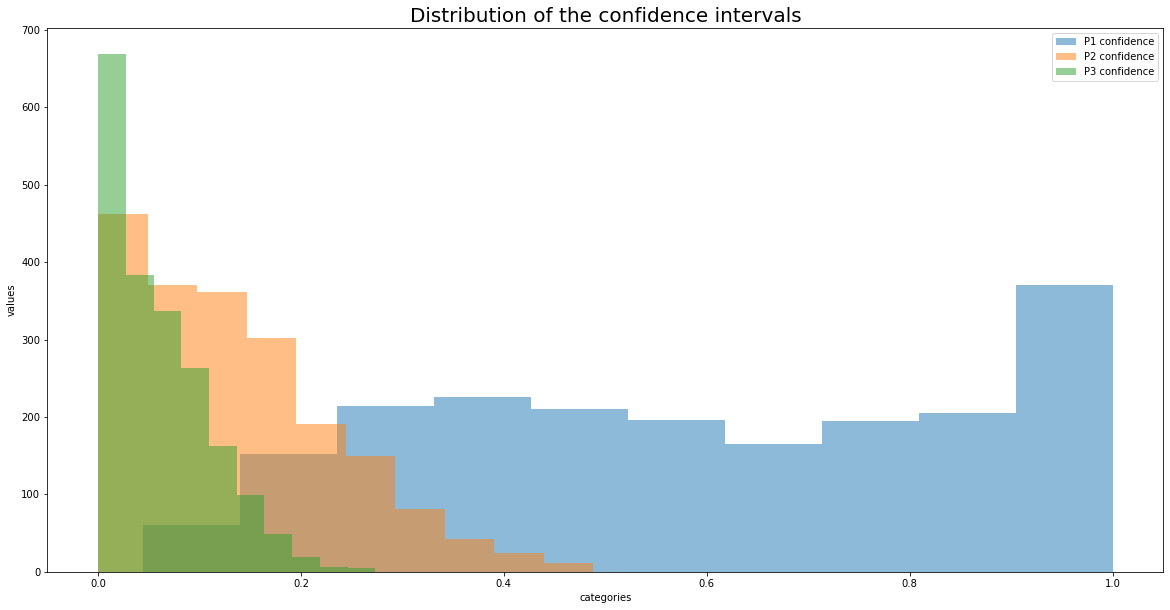

In [54]:
fig, ax=plt.subplots(figsize=(20,10))
ax.hist(df.p1_conf, alpha=0.5, label='P1 confidence')
ax.hist(df.p2_conf, alpha=0.5, label='P2 confidence')
ax.hist(df.p3_conf, alpha=0.5, label='P3 confidence')
ax.legend(loc='upper right')
#plt.xlim(-5,4000)
plt.title('Distribution of the confidence intervals', fontsize=20)
plt.xlabel('categories')
plt.ylabel('values')
plt.show();

In [55]:
df.to_csv(r'R:\Downloads\twitter_archive_master.csv', index=False)

## Insights
- p1 machine learning alogirthm seems to have the most "True" percentage of results
- pupper seems to be the most number of images corresponding to that dog stage
- Favorite count is skewed to the right 

### Reference
Udacity knowledge forum \
https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/ \
geeksforgeeks \
regex websites 